In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from pandas import concat
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

import seaborn as sns
import numpy as np
from math import sqrt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import TimeSeriesSplit
from yellowbrick.regressor import ResidualsPlot, PredictionError
from yellowbrick.model_selection import FeatureImportances


In [2]:
def getproducedata(page_nums):
    url = "http://www.producepriceindex.com/produce-price-index?field_ppi_commodity_target_id=All&field_ppi_date_value%5Bmin%5D&field_ppi_date_value%5Bmax%5D&page={}"
    tuple_data = []
    for page_num in page_nums:
        page_url = url.format(page_num)
        rawhtml = requests.get(page_url).text
        page = BeautifulSoup(rawhtml, "lxml")
        
        ttag = page.tbody
        producelist = []
        for produceitem in ttag.find_all("td", {"class": "fix-width-16"}):
            producelist.append(produceitem.text.strip())
        
        pricedatelist = []
        for pricedate in ttag.find_all("td", {"class": "fix-width-12"}):
            pricedatelist.append(pricedate.text.strip())
        pricedate_list = [pricedatelist[x:x+6] for x in range(0, len(pricedatelist),6)]
        
        spreadlist = []
        for each in ttag.find_all("td", {"class":"views-field views-field-expression-4"}):
            spreadlist.append(each.text.strip())
        
        pricedate_list = [x + [y] for x, y in zip(pricedate_list, spreadlist)]
        
        producetuples = list(zip(producelist, pricedate_list))
        tuple_data += producetuples
    
    return tuple_data


In [6]:
page_nums = list(range(638))
totalproducedata = getproducedata(page_nums)


In [9]:
produceframe = pd.DataFrame(totalproducedata, columns=['Produce','Attris'])


In [22]:
produceframe.head()

,Produce,Attris
0,Strawberries,"[2019-05-19, $1.16, $2.23, $1.70, $1.99, $2.54..."
1,Romaine Lettuce,"[2019-05-19, $0.35, $1.72, $2.00, $1.69, $1.99..."
2,Red Leaf Lettuce,"[2019-05-19, $0.32, $1.84, $1.84, $1.69, $1.89..."
3,Potatoes,"[2019-05-19, $1.50, $5.32, $5.14, $3.99, $6.22..."
4,Oranges,"[2019-05-19, $0.41, $1.42, $1.45, $1.34, $2.05..."


In [23]:
def cleanproduce(dataframe):
    #The 2nd column's data is broken up, & the 2nd column removed
    dataframe[['Date', 'Farm_Price', 'Atlanta_Retail', 'Chicago_Retail', 'LA_Retail', 'NY_Retail', 'AVGspread']] = pd.DataFrame(produceframe["Attris"].to_list(), columns=['Date', 'Farm_Price', 'Atlanta_Retail', 'Chicago_Retail', 'LA_Retail', 'NY_Retail', 'AVGspread'])
    
    # Columns made numeric with nonnumber characters removed
    for each in ['Farm_Price', 'Atlanta_Retail', 'Chicago_Retail', 'LA_Retail', 'NY_Retail']:
        dataframe[each] = pd.to_numeric(dataframe[each].str[1:])
    dataframe['AVGspread'] = dataframe['AVGspread'].replace({'\%': '', ',': ''}, regex=True).astype(float)
    produceframe['AVGspread'] = produceframe['AVGspread'] / 100
    
    # Removing data intake errors
    dataframe.dropna(inplace=True)
    dataframe = dataframe[dataframe.NY_Retail < 9]
    
    #Order the data chronologically
    dataframe = dataframe.iloc[::-1]
    # The frame can be made into a time series, a numeric index is preserved
    dataframe['Date'] = pd.to_datetime(dataframe.Date)
    dataframe['Year'] = dataframe.Date.dt.year
    dataframe['Month'] = dataframe.Date.dt.month
    dataframe["Num_Index"] = range(1, 15939)
    dataframe = dataframe.set_index('Date')
    
    # Dummie variables are created for produce category
    dataframe["Produce_"] = dataframe["Produce"]
    dataframe = pd.get_dummies(dataframe, columns=["Produce_"], prefix='Produce', drop_first=True)
    
    dataframe['AVGprice'] = dataframe[['Atlanta_Retail', 'Chicago_Retail', 'NY_Retail', 'LA_Retail']].mean(axis=1)
    
    return dataframe


In [25]:
produceframe = cleanproduce(produceframe);
del produceframe["Attris"]


In [26]:
produceframe

,Produce,Farm_Price,Atlanta_Retail,Chicago_Retail,LA_Retail,NY_Retail,AVGspread,Year,Month,Num_Index,...,Produce_Oranges,Produce_Peaches,Produce_Plums,Produce_Potatoes,Produce_Red Leaf Lettuce,Produce_Romaine Lettuce,Produce_Strawberries,Produce_Thompson Grapes,Produce_Tomatoes,AVGprice
Date,,,,,,,,,,,,,,,,,,,,,
1999-07-26,Carrots,0.14,0.64,0.00,0.49,0.74,2.3393,1999,7,1,...,0,0,0,0,0,0,0,0,0,0.4675
1999-07-26,Cauliflower,0.16,0.92,0.00,0.89,0.94,3.2969,1999,7,2,...,0,0,0,0,0,0,0,0,0,0.6875
1999-07-26,Celery,0.24,1.26,0.00,1.14,1.39,2.9479,1999,7,3,...,0,0,0,0,0,0,0,0,0,0.9475
1999-07-26,Flame Grapes,0.69,1.69,0.00,1.54,1.49,0.7101,1999,7,4,...,0,0,0,0,0,0,0,0,0,1.1800
1999-07-26,Thompson Grapes,0.92,1.69,0.00,1.34,1.49,0.2283,1999,7,5,...,0,0,0,0,0,0,0,1,0,1.1300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-19,Oranges,0.41,1.42,1.45,1.34,2.05,2.8171,2019,5,15934,...,1,0,0,0,0,0,0,0,0,1.5650
2019-05-19,Potatoes,1.50,5.32,5.14,3.99,6.22,2.4450,2019,5,15935,...,0,0,0,1,0,0,0,0,0,5.1675
2019-05-19,Red Leaf Lettuce,0.32,1.84,1.84,1.69,1.89,4.6719,2019,5,15936,...,0,0,0,0,1,0,0,0,0,1.8150


In [30]:
produceframe= produceframe.loc['2010-01-01':'2019-05-19']


In [31]:
produceframe.drop(['Atlanta_Retail','LA_Retail','NY_Retail'], axis = 1)


,Produce,Farm_Price,Chicago_Retail,AVGspread,Year,Month,Num_Index,Produce_Avocados,Produce_Broccoli Bunches,Produce_Broccoli Crowns,...,Produce_Oranges,Produce_Peaches,Produce_Plums,Produce_Potatoes,Produce_Red Leaf Lettuce,Produce_Romaine Lettuce,Produce_Strawberries,Produce_Thompson Grapes,Produce_Tomatoes,AVGprice
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-03,Celery,0.71,1.79,1.2923,2010,1,8645,0,0,0,...,0,0,0,0,0,0,0,0,0,1.6275
2010-01-03,Cauliflower,0.44,1.91,2.5966,2010,1,8646,0,0,0,...,0,0,0,0,0,0,0,0,0,1.5825
2010-01-03,Carrots,0.27,0.92,2.3519,2010,1,8647,0,0,0,...,0,0,0,0,0,0,0,0,0,0.9050
2010-01-03,Broccoli Crowns,0.37,1.89,3.7703,2010,1,8648,0,0,1,...,0,0,0,0,0,0,0,0,0,1.7650
2010-01-03,Strawberries,2.91,2.99,0.2431,2010,1,8649,0,0,0,...,0,0,0,0,0,0,1,0,0,3.6175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-19,Oranges,0.41,1.45,2.8171,2019,5,15934,0,0,0,...,1,0,0,0,0,0,0,0,0,1.5650
2019-05-19,Potatoes,1.50,5.14,2.4450,2019,5,15935,0,0,0,...,0,0,0,1,0,0,0,0,0,5.1675
2019-05-19,Red Leaf Lettuce,0.32,1.84,4.6719,2019,5,15936,0,0,0,...,0,0,0,0,1,0,0,0,0,1.8150


In [39]:
produceframe.columns

Index(['Produce', 'Farm_Price', 'Atlanta_Retail', 'Chicago_Retail',
       'LA_Retail', 'NY_Retail', 'AVGspread', 'Year', 'Month', 'Num_Index',
       'Produce_Avocados', 'Produce_Broccoli Bunches',
       'Produce_Broccoli Crowns', 'Produce_Cantaloupe', 'Produce_Carrots',
       'Produce_Cauliflower', 'Produce_Celery', 'Produce_Flame Grapes',
       'Produce_Green Leaf Lettuce', 'Produce_Honeydews',
       'Produce_Iceberg Lettuce', 'Produce_Nectarines', 'Produce_Oranges',
       'Produce_Peaches', 'Produce_Plums', 'Produce_Potatoes',
       'Produce_Red Leaf Lettuce', 'Produce_Romaine Lettuce',
       'Produce_Strawberries', 'Produce_Thompson Grapes', 'Produce_Tomatoes',
       'AVGprice', 'Window_AVG', 'Prev_AVG'],
      dtype='object')

In [33]:
def timeseriesfeatures(dataframe):
    # Last entry as well as average of last 3 prices saved
    previousprice = dataframe.groupby('Produce',  as_index=False)['AVGprice'].shift(1)
    avg3prev = previousprice.rolling(3).mean()
    
    # Dataframe of these values created & indiced 
    prevsavgs = concat([avg3prev, previousprice], axis =1)
    prevsavgs.columns = ['Window_AVG', 'Prev_AVG']
    
    # Original dataframe will aquire new features & drop resulting na
    dataframe = concat([dataframe, prevsavgs], axis = 1)
    dataframe = dataframe.dropna()
    
    return dataframe



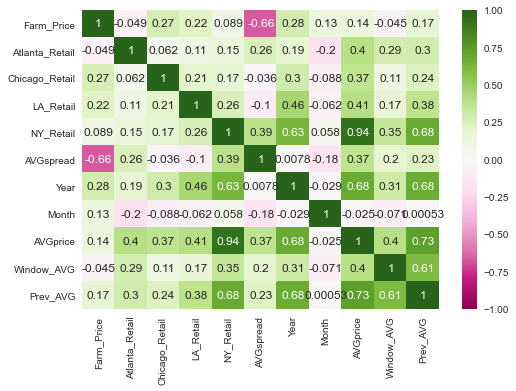

In [57]:
sns.heatmap(potato_df[['Produce', 'Farm_Price', 'Atlanta_Retail', 'Chicago_Retail',
       'LA_Retail', 'NY_Retail', 'AVGspread', 'Year', 'Month', 
       'AVGprice', 'Window_AVG', 'Prev_AVG',
        ]].corr(), cmap="PiYG", annot=True, vmin=-1, vmax=1);


In [38]:
potato_df = produceframe.loc[produceframe['Produce'] == 'Potatoes']

In [1]:
BaseURL = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'

ApiKey= APIKEY
#UnitGroup sets the units of the output - us or metric
UnitGroup='us'

#Location for the weather data
Location='Chicago,IL'

#Optional start and end dates
#If nothing is specified, the forecast is retrieved. 
#If start date only is specified, a single historical or forecast day will be retrieved
#If both start and and end date are specified, a date range will be retrieved
StartDate = ''
EndDate=''

#JSON or CSV 
#JSON format supports daily, hourly, current conditions, weather alerts and events in a single JSON package
#CSV format requires an 'include' parameter below to indicate which table section is required
ContentType="csv"

#include sections
#values include days,hours,current,alerts
Include="days"


NameError: name 'APIKEY' is not defined

In [ ]:
#basic query including location
ApiQuery=BaseURL + Location

#append the start and end date if present
if (len(StartDate)):
    ApiQuery+="/"+StartDate
    if (len(EndDate)):
        ApiQuery+="/"+EndDate

#Url is completed. Now add query parameters (could be passed as GET or POST)
ApiQuery+="?"

#append each parameter as necessary
if (len(UnitGroup)):
    ApiQuery+="&unitGroup="+UnitGroup

if (len(ContentType)):
    ApiQuery+="&contentType="+ContentType

if (len(Include)):
    ApiQuery+="&include="+Include

ApiQuery+="&key="+ApiKey
